In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib as plt
import stock_utils as su
import trader as tr
import signaller as sg
import pylab as pl
import seaborn as sns

from sklearn.externals import joblib

from sklearn.linear_model import Ridge, LinearRegression, SGDRegressor, ElasticNet, Lasso
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.mixture import GaussianMixture

%matplotlib inline

## Choose a ticker symbol and generate a dataset with selected new features for it

In [2]:
#create a dataset for AAPL
rs = 42 # random state
tickers = ['AAPL', 'MSFT', 'GOOG']
symbol = tickers[0]
window = 5
look_ahead = 1
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2016, 12, 31)
train = False
validate = False

In [3]:
if train:
    dataset = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

    data = dataset.drop(labels=['Future Price'], axis=1)
    target = dataset['Future Price']

    dataset.head()

In [4]:
if train:
    data_frame = data[['Adj. Close']]
    ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(tickers[0]))

    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend(loc='upper left')

## Find hyperparameters for model

In [5]:
if train:
    lasso = Lasso(random_state=rs)
    lasso_params = {'reg__alpha' : [0.00001, 0.0001, 0.001, 0.01, 0.1], 'reg__max_iter' : [1000, 10000, 100000, 1000000]}

    ridge = Ridge(random_state=rs)
    ridge_params = {'reg__alpha' : [10, 1, 0.1, 0.01, 0.001, 0.0001]}

    elasticnet = ElasticNet(random_state=rs)
    elasticnet_params = {'reg__alpha' : [10, 1, 0.1, 0.001, 0.0001], 'reg__l1_ratio' : [0.1, 0.3, 0.5, 0.9]}

    lin_reg = LinearRegression()

    models_params = [(lasso, lasso_params), (ridge, ridge_params), (elasticnet, elasticnet_params), (lin_reg, {})]

    scores = []
    estimators = []

    for model, params in models_params:
        class_name = model.__class__.__name__

        print ("\n{0}: \n".format(class_name))

        steps = [('scaler', StandardScaler()), ('reg', model)]
        pipe = Pipeline(steps)

        cv_splits = su.cross_val_splits(data, n_splits = 5)
        grid_search = GridSearchCV(pipe, params, cv = cv_splits)

        grid_search.fit(data, target)

        best_params = grid_search.best_params_
        print('best parameters: {0}'.format(best_params))

        best_score = grid_search.best_score_
        print('best score: {0}'.format(best_score))

        scores.append(best_score)

        best_estimator = grid_search.best_estimator_
        estimators.append(best_estimator)

## Generate training and testing datasets

In [6]:
if train:
    data = dataset.drop(labels=['Future Price'], axis=1)
    target = dataset['Future Price']
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42)

    print ('Training set has {0} samples.'.format(X_train.shape[0]))
    print ('Testing set has {0} samples.'.format(X_test.shape[0]))

In [7]:
if train:    
    model_filenames = []
    for reg in estimators:
        class_name = reg.named_steps['reg'].__class__.__name__

        print ('\n{0}: \n'.format(class_name))

        reg.fit(X_train, y_train)

        print('score for training set: {0}'.format(reg.score(X_train, y_train)))

        su.print_cross_val_accuracy(reg, X_train, y_train)

        y_hat_test = reg.predict(X_test)
        print('score for test set: {0}'.format(reg.score(X_test, y_test)))

        su.print_cross_val_accuracy(reg, X_test, y_test)

        su.plot_predictions(class_name, y_test, y_hat_test)

        filename = '{0}.pkl'.format(class_name)
        model_filenames.append(filename)

        joblib.dump(reg, filename) 

## Load saved models

In [8]:
import os
model_filenames = []
for file in os.listdir('.'):
    if file.endswith(".pkl"):
        model_filenames.append(file)

estimators = []
for filename in model_filenames:
    estimators.append(joblib.load(filename))

## Generate a validation set and test the prediction accuracy

In [9]:
if validate:
    symbol = tickers[0]
    window = 5
    look_ahead = 1
    valid_start_date = datetime.datetime(2017, 1, 1)
    valid_end_date = datetime.datetime(2017, 8, 31)

    valid_dataset = su.preprocess_data(symbol, window, look_ahead, valid_start_date, valid_end_date)

    valid_dataset.head()

In [10]:
if validate:
    pred = su.calculate_predictions_for_dataset(dataset=valid_dataset, estimators=estimators, plot_and_print=True)

## Load stock data and calculate predictions

In [18]:
symbol = 'AAPL'
test_start_date = datetime.datetime(2016, 1, 1)
test_end_date = datetime.datetime(2017, 8, 31)

dataset = su.preprocess_data(symbol, window, look_ahead, test_start_date, test_end_date)

#calculate the predicted prices
pred = su.calculate_predictions_for_dataset(dataset=dataset, estimators=estimators, plot_and_print=False)

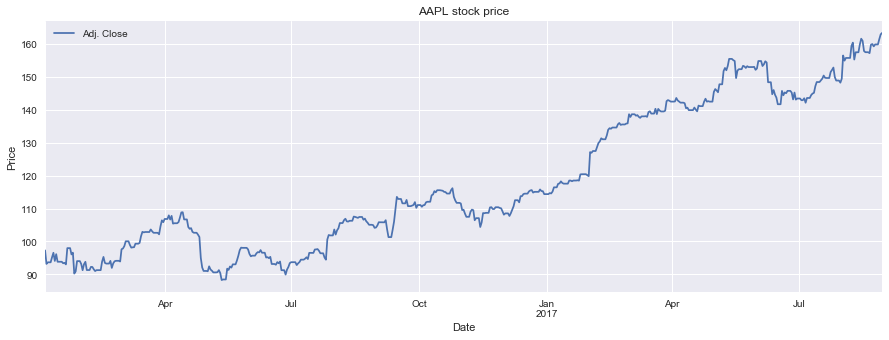

In [19]:
data_frame = dataset[['Adj. Close']]
ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

## Calculate trade signals based on the predictions

In [20]:
#add the predicted prices to the dataset
dataset['Predicted Price'] = pred

#price variation in percentage which can inform trade decisions
delta = 0.02

signaller_params = {'delta' : delta}

#calculate trade signals based on different indicators and add those signals to the dataframe
signaller = sg.Signaller(signaller_params)

dataset = signaller.calculate_trade_signal(dataset)

dataset[:100]

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price,Predicted Price,RM Signal,Percentage Signal,BB Signal,Trade Signal
2016-01-06,97.155911,98.904640,96.489269,97.291172,-0.019570,100.375119,96.280280,104.469957,-0.044139,93.185040,97.255129,0,0,0,0
2016-01-07,95.339552,96.740467,93.165717,93.185040,-0.042205,98.655374,91.465587,105.845161,-0.084480,93.677776,93.556878,0,0,0,0
2016-01-08,95.213952,95.754996,93.484546,93.677776,0.005288,97.034176,89.716985,104.351368,-0.079639,93.677776,94.179610,0,0,0,0
2016-01-09,95.213952,95.754996,93.484546,93.677776,0.000000,95.412979,90.017913,100.808045,-0.079639,93.677776,94.128364,0,0,0,0
2016-01-10,95.213952,95.754996,93.484546,93.677776,0.000000,94.301908,90.932677,97.671139,-0.055983,95.194629,94.126867,0,0,0,0
2016-01-11,95.619735,95.706688,94.044912,95.194629,0.016192,93.882599,92.354899,95.410300,-0.021549,96.576222,95.233961,0,0,0,0
2016-01-12,97.146250,97.281511,95.494039,96.576222,0.014513,94.560836,91.952607,97.169065,0.036392,94.093220,96.704422,0,0,0,0
2016-01-13,96.924036,97.764585,94.006267,94.093220,-0.025710,94.643925,92.152497,97.135352,0.004435,96.151117,94.704477,1,0,0,1
2016-01-14,94.643925,97.078619,92.499075,96.151117,0.021871,95.138593,92.624251,97.652934,0.026403,93.842021,95.876545,0,0,0,0
2016-01-15,92.943503,94.402387,92.131938,93.842021,-0.024015,95.171442,92.749949,97.592935,0.001753,93.842021,93.326173,0,0,0,0


## Find the best trading strategy for the trade signals

In [21]:
#risk behaviour levels for buying stocks: the higher the value, the higher the confidence that the signal is correct
buy_risk_levels = {'high' : 1, 'moderate' : 2, 'low' : 3}

#risk behaviour levels for selling stocks: the lower the value, the higher the confidence that the signal is correct
sell_risk_levels = {'low' : -3, 'moderate' : -2, 'high' : -1}

debug_flag = False

initial_funds = 100000

trader_configurations = [\
                         #balanced trader
                         {'name' : 'Balanced Trader', \
                          'buy_risk' : buy_risk_levels['moderate'], \
                          'sell_risk' : sell_risk_levels['moderate'], \
                          'use_signal_strength' : True, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bearish trader
                         {'name' : 'Bearish Trader', \
                          'buy_risk' : buy_risk_levels['low'], \
                          'sell_risk' : sell_risk_levels['high'], \
                          'use_signal_strength' : False,
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         },\
                         #bullish trader
                         {'name' : 'Bullish Trader', \
                          'buy_risk' : buy_risk_levels['high'], \
                          'sell_risk' : sell_risk_levels['low'], \
                          'use_signal_strength' : True, \
                          'initial_funds' : initial_funds, \
                          'debug' : debug_flag \
                         }\
                        ]

trade_df = dataset[['Adj. Close', 'Trade Signal']]

highest_profit = 0
best_trader = None

for config in trader_configurations:
    trader = tr.Trader(config)
    trader.trade(trade_df)
    
    if trader.profit > highest_profit:
        highest_profit = trader.profit
        best_trader = config['name']
    
print('Best trader for this {0} stock market data is : {1}'.format(symbol, best_trader))

Balanced Trader starts trading
Balanced Trader enters position by buying 500.0 stocks and has 51354.41$ left to invest
After 0 transactions, Balanced Trader has 500.0 stocks and 51354.41$ left in funds
Balanced Trader exits his position with a profit of 33.03%
For the same period, this particular stock cummulative return is 67.90%

Bearish Trader starts trading
Bearish Trader enters position by buying 500.0 stocks and has 51354.41$ left to invest
After 5 transactions, Bearish Trader has 0.0 stocks and 99920.92$ left in funds
Bearish Trader exits his position with a profit of -0.08%
For the same period, this particular stock cummulative return is 67.90%

Bullish Trader starts trading
Bullish Trader enters position by buying 500.0 stocks and has 51354.41$ left to invest
After 5 transactions, Bullish Trader has 1000.0 stocks and 4860.97$ left in funds
Bullish Trader exits his position with a profit of 68.21%
For the same period, this particular stock cummulative return is 67.90%

Best tra

## Let's test for another stock

In [22]:
symbol = 'GOOG'

test_start_date = datetime.datetime(2016, 1, 1)
test_end_date = datetime.datetime(2017, 8, 31)

dataset2 = su.preprocess_data(symbol, window, look_ahead, test_start_date, test_end_date)

data2 = dataset2.drop(labels=['Future Price'], axis=1)
target2 = dataset2['Future Price']

dataset2.head()

,Adj. Open,Adj. High,Adj. Low,Adj. Close,Daily return,Rolling mean 5,Lower Bollinger band 5,Upper Bollinger band 5,Cummulative return 5,Future Price
2016-01-06,730.00,747.18,728.92,743.62,0.001401,742.344,740.780056,743.907944,0.002399,726.39
2016-01-07,730.31,738.50,719.06,726.39,-0.023170,739.254,724.797807,753.710193,-0.020827,714.47
2016-01-08,731.45,733.23,713.00,714.47,-0.016410,733.780,707.959129,759.600871,-0.036895,714.47
2016-01-09,731.45,733.23,713.00,714.47,0.000000,728.306,699.586555,757.025445,-0.036895,714.47
2016-01-10,731.45,733.23,713.00,714.47,0.000000,722.684,697.101586,748.266414,-0.037855,716.03


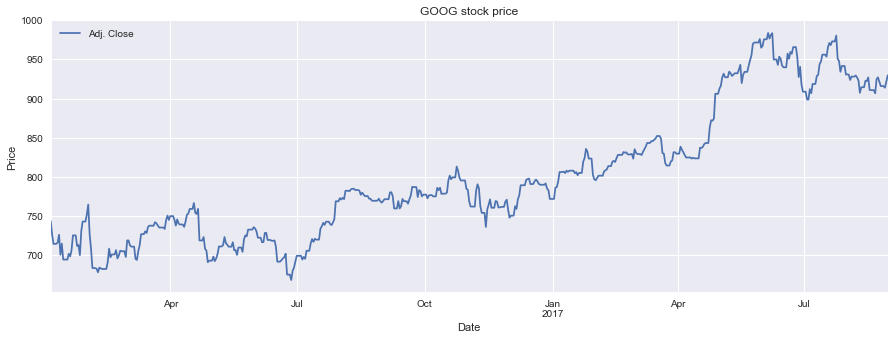

In [23]:
data_frame = data2[['Adj. Close']]
ax = data_frame.plot(figsize=(15,5), grid=True, title='{0} stock price'.format(symbol))

ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')

In [24]:
dataset2 = su.preprocess_data(symbol, window, look_ahead, start_date, end_date)

pred2 = su.calculate_predictions_for_dataset(dataset=dataset2, estimators=estimators, plot_and_print=False)

dataset2['Predicted Price'] = pred2

dataset2 = signaller.calculate_trade_signal(dataset2)

dataset2_df = dataset2[['Adj. Close', 'Trade Signal']]

highest_profit = 0
best_trader = None

for config in trader_configurations:
    trader = tr.Trader(config)
    trader.trade(dataset2_df)
    
    if trader.profit > highest_profit:
        highest_profit = trader.profit
        best_trader = config['name']
    
print('Best trader for this {0} stock market data is : {1}'.format(symbol, best_trader))

Balanced Trader starts trading
Balanced Trader enters position by buying 0.0 stocks and has 100000.00$ left to invest
After 0 transactions, Balanced Trader has 0.0 stocks and 100000.00$ left in funds
Balanced Trader exits his position with a profit of 0.00%
For the same period, this particular stock cummulative return is 38.21%

Bearish Trader starts trading
Bearish Trader enters position by buying 0.0 stocks and has 100000.00$ left to invest
After 0 transactions, Bearish Trader has 0.0 stocks and 100000.00$ left in funds
Bearish Trader exits his position with a profit of 0.00%
For the same period, this particular stock cummulative return is 38.21%

Bullish Trader starts trading
Bullish Trader enters position by buying 0.0 stocks and has 100000.00$ left to invest
After 1 transactions, Bullish Trader has 100.0 stocks and 44154.00$ left in funds
Bullish Trader exits his position with a profit of 21.34%
For the same period, this particular stock cummulative return is 38.21%

Best trader f